# Data classification - Titanic survival - Decision trees

Given their transparency and relatively low computational cost, Decision Trees are also very useful for exploring your data before applying other algorithms. They're helpful for checking the quality of engineered features and identifying the most relevant ones by visualizing the resulting tree.
The main downsides of decision Trees are their tendency to over-fit, their inability to grasp relationships between features (It is the job of on-supervised mapping algorithms...), and the use of greedy learning algorithms (not guaranteed to find the global optimal model). Using them in a Random Forest helps mitigate some of this issues.


The titanic dataset has two challenges first we need to perform a very hard cleaning and some features needs to be engineered. The methods used in the feature engineering will influences the final predictions with any ML algorithm. The more we dive into the titanic dataset to clean it more we fine interesting information hidden in the dirty not structured table columns. the final objective is to built a model, train it with the train_data and try to predict the passengers that survived and the one that unfortunately not survived to the sinking.


Here I perform the cleaning of the columns and perform feature engineering to prepare the variables to the be inputs to a decision tree model and also engineered new features from information hidden in the columns "Name", "Ticket" and others. We employed a decision tree to estimate the missing values of the engineered feature "Age_group" and finally we used the clean dataset and the new features to train a decition tree to predict the Survived target variable. We optimized the hyperparameters of the tree using cross-validation pre-pruing (with GridSearchCV) and also post-pruning by plotting the cross-validate accuracy with the ccp_alpha values and visualizing the point where the tree starts to overfit. We obtained test accuracy values between 0.78 for the test_data and 0.83 for the train accuracy score. Decision trees are simple learners, it is not suitable to hard predicting jobs, but it helps a lot in visualization of the feature importance and the inter-relationships between then to predict a given target feature.


In [1]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re

import seaborn as sns
from ipywidgets import interact
import matplotlib.pyplot as plt
from mpl_interactions import ioff, panhandler, zoom_factory
# %matplotlib widget
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# import xgboost as xgb



# Load and explore the data

In [2]:
# Load the data
train = pd.read_csv('titanic_datasets/train.csv')
test = pd.read_csv('titanic_datasets/test.csv')
# concatenate train and test in same dataframe to perform data cleaning and feature engineering n both parts.
df = pd.concat([train, test], ignore_index = True, sort = False)
train_idx = df['Survived'].notnull()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory data analysis

* Check the missing values and data types
* Make Barplots for some variables couting the survived and non survived.
* Make Heatmap correlation plots to see the inter-relationships between the variables and between the Survived and the other variables.

In [3]:
# Customized summary
nan_counts = df.isna().sum().sort_values(ascending = False)
summary = pd.concat([df.info(), nan_counts], axis=0)
print(summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
PassengerId       0
Pclass            0
Name              0
Sex               0
SibSp             0
Parch             0
Ticket            0
d

# Cleaning and feature engineering the dataset

The titanic dataset contains missing values, incomplete columns. Some rows contains more than one information per column as we can see in the column Cabin that containg more than one cabin per person. The column "Name" contains name and title. The variable "Ticket" contains the number and a prefix code. Some passangers has the same Ticket code. The columns SibSp (Siblings and Spouses) and the column Parch, gives information about the number of family members aboard and the family structure but siblings info is mixed with spouses info, in the same way the variable "Parch" mix info about childs and parents. The Name (without the title) and the Embarked city may not contribute to the prediction. the PassengerId will be keeped to compose the submission prediction table for Kaggle.

The more criretious aproach is to perform cleaning and engineer some fearures before apply rules to the fill the NaN values. We can create the feature "Title" by extracting from the column "Name" the titles: Mr. Miss. Mrs. Dr. and others.(see also [Sina "Tinatic best working classifier"](https://www.kaggle.com/code/sinakhorami/titanic-best-working-classifier)). This idea can be employed also to extract information of the Ticket preffix. Maybe this preffix tells something about the status of the passenger. The Cabin information can be very informative as the distance from the The boat deck where the lifeboats were located may influence the change of survival. But this column is not structured and has mostly missing values. To solve this we can try to split this column into three columns: **['Cabine_label', 'Cabine_number', 'N_of_Cabins reserved']**. Is is not easy to find a criteria to fill missing values (NaN) and maybe the work is to much hard but at the end this varible can be discarted by the model due to inefficienty in predicting the survival propability. The variale Age will be cathegorized into ranges and we will employ a simple decision tree with the other variables to help in filling the missin data about the Age. It is impossible to predict the exact Age of the passenger but we can try to predict the Age_group. The good aspect of the decision trees is that in principle we dont have to worry about the feature importance because the algorithm will rank it for us and we can visualize the learned and acquire information about the feature importances.

In the nexts sections we will perform cleaning and feature engineering on the titanic dataset so we can apply more sofisticated exploratory data analysis and employ it to train and test a ML model.

1. Map 'Sex' to 'Sex_bool'.
2. Map 'Embarqued' to Embarqued_code{1,2,3}. reserve the zero for NaN.
3. Split the variable 'Ticket' into 'Ticket_preffix', 'Ticket_n'.
4. Group the duplicated Ticket values and count the number of people that travels together including friends, maids, nanys and create the variable 'Companions',
5. Create the variable 'FamilySize' by combining the variables 'SibSp' and 'Parch'
6. Extract the variable 'Title' from the variable 'Name' and cathegorize. 
4. Map 'Fare' to 'Fare_range': {0,1,2,3}.
5. The most dirty variable 'Cabin' -> split it into ['Cabin_label', 'Cabin_n', 'n_of_Cabins'].
6. Engineer the variable Age_group and predict the missing values using a ML decision tree model trained with the non-missing entries.

## Sex

Encode the Variable 'Sex' to 'Sex_bool'

In [4]:
# Mapping Sex bolean
df['Sex_bool'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

## Embarked

Clean the variable 'Embarked' fill  the NaN and encode  it to numerical values.

In [5]:
# Check the entries with NaN vales.
df.loc[df['Embarked'].isna(),:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_bool
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0


We see both passangers share the variable values, Sex = female, Pclass = 1, they were in the same Cabin = B28, and the Ticket number is the same Ticket = 113572. Do you think it is a coincidence? I think Not!. If we try to see the number of passangers with this characteristics will guess the Embarked being either C or S. Alernativelly we can google seach for it and find that:
Mrs Stone boarded the Titanic in **Southampton** on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.([encyclopedia titanica](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html))

In [6]:
# filter and count the most frequent values
df.loc[(df['Sex'] == 'female') & (df['Pclass'] == 1), 'Embarked'].value_counts(dropna= False)

Embarked
C      71
S      69
NaN     2
Q       2
Name: count, dtype: int64

In [7]:
# Fill the NaN and map Embarked to numerical codes
df.loc[df['Embarked'].isna(), 'Embarked'] = 'S'  # (Encyclopedia titanica)
df['Embarked_code'] = df['Embarked'].map( {'S': 1, 'C': 2, 'Q': 3} ).astype(int)

## Ticket

Split the 'Ticket' into the 'Ticket_preffix' and 'Ticket_number'

In [8]:
# split the column 'Ticket'
Ticket_split = []
Ticket_len = []
for i in df['Ticket'].index:
    splitted = df.loc[i,'Ticket'].split(' ')
    Ticket_split.append(splitted)
    length = len(splitted)
    Ticket_len.append(length)
    
df['Ticket_split'] = Ticket_split
df['Ticket_len'] = Ticket_len

# df[['Ticket_len']].value_counts()
# df.loc[df['Ticket_len'] > 2, :] We can see tome typo errors.

# Create columns Ticket_preffix and Ticket_number
ticket_preffix = []
ticket_number = []
for i in df['Ticket'].index:
    ticket_parts = df.loc[i, 'Ticket_split']
    number = ticket_parts[-1]
    ticket_number.append(number)
    length = df.loc[i, 'Ticket_len'].item()
    if length > 1:
        preffix = ''.join(ticket_parts[0:-1])
        ticket_preffix.append(preffix)
    else:
        ticket_preffix.append('blanck')
        
df['Ticket_preffix'] = ticket_preffix
df['Ticket_number'] = ticket_number
# drop unnecessary columns created
df.drop(columns=['Ticket_split', 'Ticket_len'], inplace=True)

df.Ticket_preffix.unique()

array(['A/5', 'PC', 'STON/O2.', 'blanck', 'PP', 'A/5.', 'C.A.', 'A./5.',
       'SC/Paris', 'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C',
       'W./C.', 'SOTON/OQ', 'W.E.P.', 'A4.', 'C', 'SOTON/O.Q.',
       'SC/PARIS', 'S.O.P.', 'A.5.', 'Fa', 'CA.', 'F.C.C.', 'W/C',
       'SW/PP', 'SCO/W', 'P/PP', 'SC', 'SC/AH', 'A/S', 'SC/AHBasle',
       'A/4', 'WE/P', 'S.W./PP', 'S.O./P.P.', 'F.C.', 'SOTON/O2',
       'S.C./PARIS', 'C.A./SOTON', 'SC/A.3', 'STON/OQ.', 'SC/A4', 'AQ/4',
       'A.2.', 'LP', 'AQ/3.'], dtype=object)

In [9]:
df_grouped = df.groupby(['Ticket_preffix', 'Embarked']).agg({'Survived': ['sum', lambda x: x.count() - x.sum()]})
df_grouped.columns = ['Survived', 'Non-Survived']
# df_grouped['Count'] = df.groupby(['Title', 'Sex']).size()
print(df_grouped)

                         Survived  Non-Survived
Ticket_preffix Embarked                        
A./5.          S              0.0           2.0
A.2.           S              0.0           0.0
A.5.           S              0.0           2.0
A/4            S              0.0           3.0
A/4.           S              0.0           3.0
A/5            S              1.0           9.0
A/5.           Q              0.0           1.0
               S              1.0           5.0
A/S            S              0.0           1.0
A4.            S              0.0           1.0
AQ/3.          Q              0.0           0.0
AQ/4           Q              0.0           0.0
C              S              2.0           3.0
C.A.           C              0.0           0.0
               S             13.0          14.0
C.A./SOTON     S              0.0           1.0
CA             S              0.0           6.0
CA.            S              1.0           7.0
F.C.           C              0.0       

The column Tiket_preffix has some typo erros and seems to be related to the 'Embarked' info. Most of valuas are Blank and maybe it wont worth to analyse the survival probability.

Moreove, we already observed that the Ticket_number has some duplicated entries. Some passangers share the ticket number because they are together. They can have a relarionship of employee or servicing like a maid or a nany, or  they can be close friends. These relationships were not all captured in the variables SibSp and Parch. See, for example, the case of Mrs Stone boarded that was travelling with her maid Amelie Icard and both survived ([encyclopedia titanica](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html)).

In the following line we start to do some Feature engineering. We not just clean the variable but we are extracting inplicit information and creating a nem varible to describe it. Let us add this information to the column 'Companions' describing the number of companions or fellow passengers for each individual. Maybe this number make some impact on the survival probabylity. 

In [10]:
df['Ticket_number'].duplicated(keep=False).astype(int).value_counts()
# (df.groupby('Ticket')['Ticket'].transform('count') - 1)

Ticket_number
0    705
1    604
Name: count, dtype: int64

In [11]:
df['Companions'] = df['Ticket'].duplicated(keep=False).astype(int) * df.groupby('Ticket')['Ticket'].transform('count') -1 
df.loc[df['Companions'] == -1, 'Companions'] = 0
df['Companions'].value_counts()

Companions
0     713
1     264
2     147
3      64
4      35
6      35
5      24
7      16
10     11
Name: count, dtype: int64

## Famyly size as a sum of SibSp and Parch

This is a feature engineering step as we are creating a new feature by combining two existing ones. The variables SibSp and Parch describe the family structure aboard for each passenger. However, the specific level of parental relationships may not be important; only the total number of family members may matter. In this case, these variables are redundant.


In [12]:
df['FamilySize'] = df['SibSp'] + df['Parch']
print(df[['SibSp','Parch','FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by = 'Survived'))

   FamilySize     SibSp     Parch  Survived
7           7  4.000000  3.000000  0.000000
8          10  6.727273  3.272727  0.000000
5           5  2.800000  2.200000  0.136364
4           4  2.000000  2.000000  0.200000
0           0  0.000000  0.000000  0.303538
6           6  3.250000  2.750000  0.333333
1           1  0.778723  0.221277  0.552795
2           2  0.893082  1.106918  0.578431
3           3  1.302326  1.697674  0.724138


## Vaviable 'Name' and corresponding 'Title'

Now we will extrat the 'Title' information from the variable 'Name'. We can create the feature "Title" by extracting from the column "Name" the titles: Mr. Miss. Mrs. Dr. and others.(see also [Sina "Tinatic best working classifier"](https://www.kaggle.com/code/sinakhorami/titanic-best-working-classifier)). 

In [13]:
# get the 'Title'
def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

df['Title'] = df['Name'].apply(get_title)

df_grouped = df.groupby(['Title', 'Sex']).agg({'Survived': ['sum', lambda x: x.count() - x.sum()]})
df_grouped.columns = ['Survived', 'Non-Survived']
df_grouped['Count'] = df.groupby(['Title', 'Sex']).size()
print(df_grouped)

                 Survived  Non-Survived  Count
Title    Sex                                  
Capt     male         0.0           1.0      1
Col      male         1.0           1.0      4
Countess female       1.0           0.0      1
Don      male         0.0           1.0      1
Dona     female       0.0           0.0      1
Dr       female       1.0           0.0      1
         male         2.0           4.0      7
Jonkheer male         0.0           1.0      1
Lady     female       1.0           0.0      1
Major    male         1.0           1.0      2
Master   male        23.0          17.0     61
Miss     female     127.0          55.0    260
Mlle     female       2.0           0.0      2
Mme      female       1.0           0.0      1
Mr       male        81.0         436.0    757
Mrs      female      99.0          26.0    197
Ms       female       1.0           0.0      2
Rev      male         0.0           6.0      8
Sir      male         1.0           0.0      1


We now clean and cathegorize the Titie variable then check the title impact on survival rate.

In [14]:
# Clean the varianle Title.
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'noble')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Mrs')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Check the survival rate for the title cathegories obtained
df_grouped = df.groupby(['Title', 'Sex']).agg({'Survived': ['sum', lambda x: x.count() - x.sum()]})
df_grouped.columns = ['Survived', 'Non-Survived']
df_grouped['Count'] = df.groupby(['Title', 'Sex']).size()
# Calculate the survived/non-survived rate
df_grouped['Survival Rate'] = df_grouped['Survived'] / (df_grouped['Survived'] + df_grouped['Non-Survived'])
# Order the DataFrame by the survival rate in descending order
df_grouped = df_grouped.sort_values('Survival Rate', ascending=False)

print(df_grouped)

               Survived  Non-Survived  Count  Survival Rate
Title  Sex                                                 
noble  female       3.0           0.0      4       1.000000
Mrs    female     101.0          26.0    200       0.795276
Miss   female     129.0          55.0    262       0.701087
Master male        23.0          17.0     61       0.575000
noble  male         5.0          15.0     25       0.250000
Mr     male        81.0         436.0    757       0.156673


We can see that be a noble make a very difference in the Titanic. The other titles reflect the sex and the age of the passanger. We can observe that the survival rate for man with title master is better than those with title Mr, althogh, it can be interpreted by the age whereas younger man has a better chance to survive. If we compare the survival rate of womens, the Miss. title survive less than Mrs. title. It can indicate the status of the woman as maried or not can make a difference. But we all agree that the information about the family and the age has its own features to descibe. The exclusive information we can obtain from title feature is, if the passager own noble title or not.

In [15]:
df['noble'] = df['Title'].apply(lambda x: 1  if x =='noble'  else 0)
df['noble'].value_counts()

noble
0    1280
1      29
Name: count, dtype: int64

## Fare

We can substitute the only one Fare missing value by the median value. Then we categorize it the 'Fare' variable into 4 group ranges.

In [16]:
df.loc[df['Fare'].isna(),:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_bool,Embarked_code,Ticket_preffix,Ticket_number,Companions,FamilySize,Title,noble
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,1,blanck,3701,0,0,Mr,0


In [17]:
# fill with  the median for the Pclass and Sex.
df.loc[df['PassengerId'] == 1044, 'Fare'] = df.loc[(df['Pclass'] == 3) & (df['Sex'] == 'male'), 'Fare'].median()
print(df.loc[df['PassengerId'] == 1044, 'Fare'])

1043    7.8958
Name: Fare, dtype: float64


In [18]:
## Fare ranges
df['Fare_range'] = pd.qcut(df['Fare'], 9)
print (df[['Fare_range', 'Survived']].groupby(['Fare_range']).mean())

                 Survived
Fare_range               
(-0.001, 7.733]  0.155340
(7.733, 7.896]   0.233333
(7.896, 8.662]   0.200000
(8.662, 13.0]    0.375000
(13.0, 16.1]     0.363636
(16.1, 26.0]     0.460784
(26.0, 35.917]   0.445545
(35.917, 73.5]   0.474227
(73.5, 512.329]  0.762887


In [19]:
df['Fare_range'] = pd.qcut(df['Fare'], 9, labels=[0, 1, 2, 3, 4, 5 ,6 ,7, 8])

# Check the survival rate for the fare categories obtained
df_grouped = df.groupby(['Fare_range', 'Sex']).agg({'Survived': ['sum', lambda x: x.count() - x.sum()]})
df_grouped.columns = ['Survived', 'Non-Survived']
# Calculate the survival rate
df_grouped['Survival Rate'] = df_grouped['Survived'] / (df_grouped['Survived'] + df_grouped['Non-Survived'])
# Order the DataFrame by the survival rate in descending order
df_grouped = df_grouped.sort_values('Survival Rate', ascending=False)

print(df_grouped)


                   Survived  Non-Survived  Survival Rate
Fare_range Sex                                          
8          female      60.0           2.0       0.967742
7          female      30.0           6.0       0.833333
0          female      10.0           3.0       0.769231
3          female      34.0          12.0       0.739130
5          female      38.0          16.0       0.703704
1          female      20.0          10.0       0.666667
6          female      20.0          13.0       0.606061
4          female      17.0          12.0       0.586207
8          male        14.0          21.0       0.400000
6          male        25.0          43.0       0.367647
2          female       4.0           7.0       0.363636
7          male        16.0          45.0       0.262295
4          male         7.0          30.0       0.189189
5          male         9.0          39.0       0.187500
2          male        13.0          61.0       0.175676
3          male        11.0    

## Cabin

This is the most dirty column, mostly values are missing and some rows contains more than one information about the Cabin: more than one cabine for some passangers. The Cabin information can be very informative as the distance from the The boat deck where the lifeboats were located may influence the change of survival. But this column is not structured and has mostly missing values. To solve this we can try to split this column into three columns: ['Cabine_label', 'Cabine_number', 'N_of_Cabins reserved'] and analyse this three colums together with the Fare value and the number of family members aboard in such a way that we can try to predict the missing values at least for the missing cabin_label. We could apply a simple rule and estimate the missing Cabin_label by mapping the variable Fare or we could use a a supervised simple algoritm like decision tree to perform multilassification of the Cabin_label based on the non-missing cabin_label rows as a train set. Is is not easy to fine a criteria to fill NaN values and the volume of known data is to small compared to unknown data. I think the work to fill or extimate an engineered feeature with this information is to much hard and at the end this varible could be discarted by the model due to inefficienty in predicting the survival propability.

In [20]:
# Get the label of the last reserved cabin if exists
# get the last cabin if exists
df['Last_cabin'] = df['Cabin'].apply(lambda x: str(x).split()[-1] if pd.notnull(x) else 'N')

# get the Cabin_label of the last cabin
pattern = r'([A-Za-z])'
df['Cabin_label'] = df['Last_cabin'].apply(lambda x: re.search(pattern, str(x)).group(1) if x != 'N' else 'N')

# Get the number of the last cabin if exists
pattern = r'(\d+)'
df['Cabin_number'] = df['Last_cabin'].apply(lambda x: re.search(pattern, str(x)) if x != 'N' else -1)

# Get the number of distinct cabins reserved by the passenger.
df['Cabin_count'] = df['Cabin'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)


In [21]:
# drop not used columns
df.drop(columns = ['Last_cabin', 'Cabin_number'], inplace = True)

## Mapping Age

Age groups can be much more informative than the exact value. We still have the problem of Age missing values.

In [22]:
# Mapping Age
df.loc[ df['Age'] <= 13, 'Age_group'] = 0 # kids
df.loc[(df['Age'] > 13) & (df['Age'] <= 35), 'Age_group'] = 1 # young
df.loc[(df['Age'] > 35) & (df['Age'] <= 55), 'Age_group'] = 2 # mature
df.loc[(df['Age'] > 55) & (df['Age'] <= 120), 'Age_group'] = 3 # old

print('Counts: ', df['Age_group'].value_counts(dropna=False))

Counts:  Age_group
1.0    625
2.0    263
NaN    263
0.0     99
3.0     59
Name: count, dtype: int64


We need to find a way to fill the missing Age_group values. Age must be related to the other variables and I think we can predict the age_group using the variables 'Pclass', 'Title', 'Fare', 'SibSp'and 'Parch' and the other variables can give a little help maybe. It is obvious for example that a passanger with a title = Master. is a young boy. Let us try to predidict the Age_group using a decision tree multiclass.

sinse the variable 'Tite' dont has a an inherent order it is better to apply one-hot encoding to this variable before inputting in the model.

In [23]:
features = ['Pclass', 'SibSp', 'Parch','FamilySize', 'Fare', 'Sex_bool','Embarked_code', 'Companions', 'Cabin_count', 'Age_group', 'Title']

The variable 'Title ' is very important in preficting the Age_group although it is a factor with more than 4 values and we can not attribute an order to each label. In thie case we have to use one-hot encoding to this variable to make it suitable to the training in the ML model.

In [24]:
encoded = pd.get_dummies(df['Title'], prefix='Title')
df = pd.concat([df, encoded], axis=1)
encoded.head()

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_noble
0,False,False,True,False,False
1,False,False,False,True,False
2,False,True,False,False,False
3,False,False,False,True,False
4,False,False,True,False,False


In [25]:
# Load the data for training and validation the rows where Age is not NaN.
features = ['Pclass', 'SibSp', 'Parch','FamilySize', 'Fare_range', 'Sex_bool', 'Companions', 'Cabin_count',
            'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_noble']
X = df.loc[~df['Age'].isna(), features] 
Y = df.loc[~df['Age'].isna(), 'Age_group'] # the target variable we want o train for is Age_group

# Let us split the training set into train and valiication
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=22)

print('X_train.shape', X_train.shape)
print('Counts: ', Y_train.value_counts(dropna = False))

X_train.shape (732, 13)
Counts:  Age_group
1.0    447
2.0    173
0.0     67
3.0     45
Name: count, dtype: int64


In [26]:
#  Build a Decision Tree, to predict the Age_group.
from sklearn import tree
tree_age = tree.DecisionTreeClassifier(max_depth= 5,
                                       min_samples_leaf =10,
                                       min_samples_split = 10,
                                       ccp_alpha = 0.005
                                      )
tree_age.fit(X_train, Y_train)
Y_pred = tree_age.predict(X_val)

# Calculate the train and Validation accuracy of the model.
train_acc = tree_age.score(X_train, Y_train)
from sklearn.metrics import accuracy_score
val_acc = accuracy_score(Y_val, Y_pred)
print("train_Accuracy:", train_acc)
print("val_Accuracy:", val_acc)


train_Accuracy: 0.7295081967213115
val_Accuracy: 0.6910828025477707


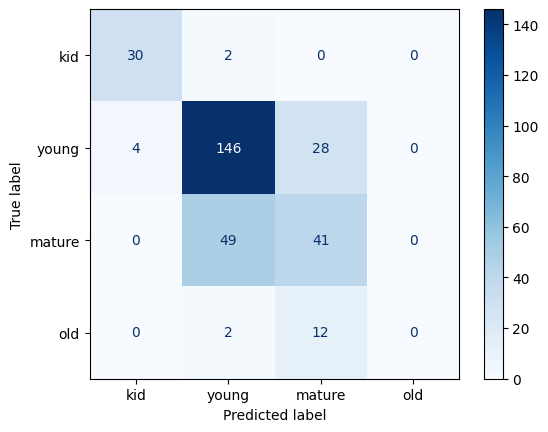

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
labels = ['kid', 'young', 'mature', 'old']
# labels = tree_age.classes_
ConfusionMatrixDisplay.from_predictions(Y_val, Y_pred, display_labels = labels, cmap = plt.cm.Blues)
plt.show()

Let us see how the tree predict the Age_groups in the plot of the decsion tree below.

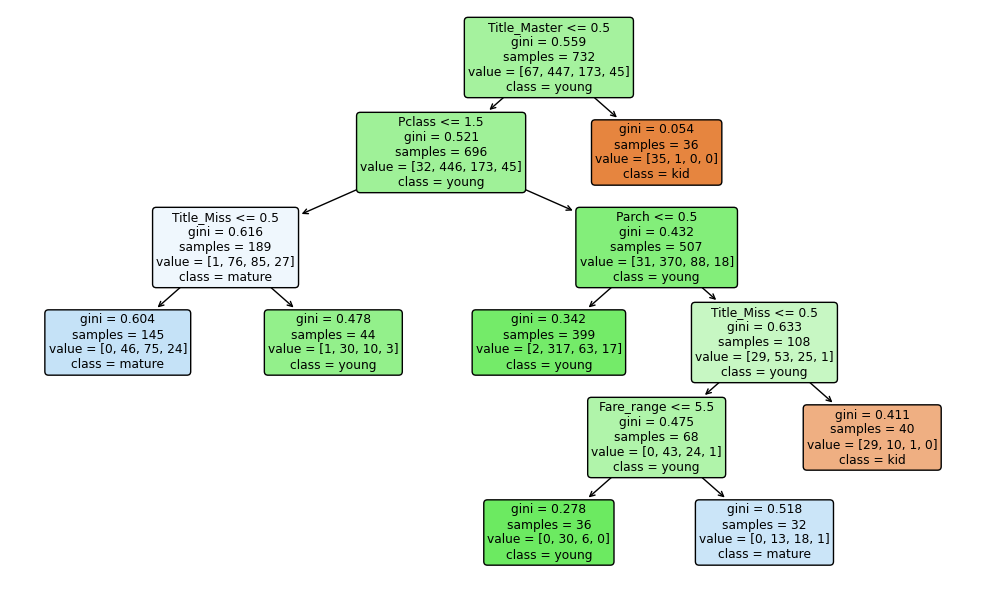

In [28]:
# Generate the decision tree plot
fig, ax = plt.subplots(figsize=(10, 6))
tree.plot_tree(tree_age, feature_names=features, class_names=['kid', 'young', 'mature', 'old'], filled=True, rounded=True, ax=ax)
# Adjust the layout of subplots
plt.tight_layout()
# Display the plot
# plt.show()

# Save the figure with higher resolution
plt.savefig('Tree_age.png', dpi=300)

Use GridSearchCV process to make the hyperparameters tunning of the decision tree. We can try to optimize by pre-pruning with the parameters [max_depth, min_samples_leaf, min_samples_split], or we can tunne using post-pruning process with the cost complexity pruning this parameterccp_alpha.

In [29]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    # 'max_depth': [ 6 , 7 , 8, 9],    
    # 'min_samples_leaf': [6,7, 8, 9, 10],
    # 'min_samples_split': [6, 7, 8, 9, 10, 11, 12],
    'ccp_alpha': [0.0001, 0.004, 0.006, 0.007, 0.008, 0.009,  0.0010, 0.0012]
}

# Create the decision tree classifier
model = tree.DecisionTreeClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
grid_search.fit(X, Y)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'ccp_alpha': 0.004}
Best Score: 0.7151739926739926


Finally we will use the trained and optimized decision tree to fill the missing Age_group values i our train and test dataset.

In [30]:
X_test = df.loc[df['Age_group'].isna(), features]
Age_group_pred = tree_age.predict(X_test)

# Fill the NaN values in Age_group
df.loc[df['Age_group'].isna(), 'Age_group'] = Age_group_pred

In [31]:
I will finish here the dataset cleaning and feature engineering but I am sure that there is a plenty of information hidden in the variable 'Name', 'Cabin' and 'ticket', and someone with more patiance can dive into and explore.

SyntaxError: invalid syntax (3383888871.py, line 1)

In [ ]:
# Drop the columns that are incomplete and will not be used to further analysis
df.drop(columns = ['Age', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs','Ticket', 'Cabin','noble', 'Embarked'], inplace = True)
print(df.columns)
# Check the variables with NaN values.
nan_counts = df.isna().sum().sort_values(ascending = False)
print('NaN in Train_data:\n', nan_counts)

In [ ]:
# Expor the .csv file
df.to_csv('titanic_cleaned.csv', index = False)

# Exploratory analysis

We can make some exploratory analysis with the original complete and the new engineered features.

In [ ]:
# df = pd.read_csv('titanic_datasets/titanic_cleaned.csv')
# df.head()

In [ ]:
def plot_countplot(variable='Sex'):
    # Calculate the counts
    counts = df[variable].value_counts()
    
    # Calculate the probability of survival
    survived = df[df['Survived'] == 1][variable].value_counts().sort_index()
    not_survived = df[df['Survived'] == 0][variable].value_counts().sort_index()
    survival_prob = survived / (survived + not_survived)

    # Create subplots with shared x-axis
    fig, ax1 = plt.subplots()   
    
    # Plot the survival probability using scatter plot markers and lines on the left y-axis
    ax1.plot(survival_prob.index, survival_prob.values, marker='o', linestyle='-', color='red')
    ax1.set_ylabel('Survival Probability', color='black')
    ax1.tick_params(axis='y', labelcolor='red')    
    
    # Create a twin y-axis for the left side
    ax2 = ax1.twinx()
    
    #Plot the count bars on the right y-axis
    ax2.bar(counts.index, counts.values, alpha=0.4, width=0.2, color='royalblue')
    ax2.set_ylabel('Counts', color='black')
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # Set the x-axis label and title
    ax1.set_xlabel(variable)
    plt.title('Count and Survival Probability')
    
    # Adjust the layout of subplots
    plt.tight_layout()

# Call the interact function
interact(plot_countplot, variable=df.columns)


## What is the profile of the passengers that has no Cabin_label info, Cabin_label = N

Analysing the distributions of the features in each cabin label It seems that the Cabin_label N can be any cabin because the profiles of the Cabin_label N are very close to the profile of all cabins mixed. The missing of the cabin info is not related to a given Pclass, Sex, Age_group. It is randomly distributed. That is why it is very hard to use this feature in a meaningfull way.

In [ ]:
# Filter the DataFrame for passengers with cabin label 'N'
cabin_N_passengers = df[df['Cabin_label'] == 'N']
# cabin_N_passengers = df

fig, axes = plt.subplots(2, 4, figsize=(20, 8))

# Plot the distribution of classes
sns.countplot(x='Pclass', data=cabin_N_passengers, ax=axes[0,0], width=0.5)
axes[0,0].set_title('Passenger Class Distribution for Cabin Label N')

# Plot the distribution of sex
sns.countplot(x='Sex', data=cabin_N_passengers, ax=axes[0,1], width=0.3)
axes[0,1].set_title('Sex Distribution for Cabin Label N')

# Plot the distribution of fare
sns.countplot(x='Fare_range', data=cabin_N_passengers, ax=axes[0,2], width=0.5)
axes[0,2].set_title('Fare Distribution for Cabin Label N')

# Plot the distribution of fare
sns.countplot(x='Age_group', data=cabin_N_passengers, ax=axes[0,3], width=0.5)
axes[0,3].set_title('Age_group Distribution for Cabin Label N')

# Plot the distribution of fare
sns.countplot(x='Embarked_code', data=cabin_N_passengers, ax=axes[1,0], width=0.5)
axes[1,0].set_title('Embarked_code Distribution for Cabin Label N')

# Plot the distribution of fare
sns.countplot(x='FamilySize', data=cabin_N_passengers, ax=axes[1,1], width=0.5)
axes[1,1].set_title('Familysize Distribution for Cabin Label N')
# Plot the distribution of fare
sns.countplot(x='Companions', data=cabin_N_passengers, ax=axes[1,2], width=0.5)
axes[1,2].set_title('Companions Distribution for Cabin Label N')

# Plot the distribution of fare
sns.countplot(x='Title', data=cabin_N_passengers, ax=axes[1,3], width=0.5)
axes[1,3].set_title('Title Distribution for Cabin Label N')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
def plot_countplot(variable = 'Sex'):
    sns.countplot(x=variable, hue='Survived', data=df)

interact(plot_countplot, variable=df.columns)

## Correlations

Let us Check the correlation between the variables of the dataset

In [ ]:
# print(train_data.corr())
corrMatrix = df[train_idx].loc[:, ['Pclass', 'Sex_bool', 'Age_group', 'FamilySize', 'Survived', 'Fare']].corr()
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)

# Survival classification with Decision Tree

In the dataset we have a test part for which we don't know the 'Survived' value and we will ultimatelly test the model with the Test_data and submit the results to Kaggle and obtain the accuracy score. The part od the dataset where we know the 'Survived' value we will use to train and validate the model. 

In [ ]:
Test_data = df.loc[df['Survived'].isna()]
Train_data = df.loc[~df['Survived'].isna()]

In [ ]:
Train_data.columns

In [ ]:
# Load the data for training and validation
features = ['Pclass','Sex_bool', 'SibSp', 'Parch',
       'Companions', 'FamilySize', 'Fare_range',
       'Cabin_count', 'Age_group', 'Title_noble']

X = Train_data[features] # training dataset
Y = Train_data['Survived']

# Let us split the training set into train and valiication
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.30, random_state=42)

#  Build a decision Tree, train and validate the model.
from sklearn import tree
modeltree1 = tree.DecisionTreeClassifier(criterion='gini',
                                        max_depth= 5, # 5, 5, None,
                                        min_samples_leaf = 2, # 5, None, 
                                        min_samples_split = 2, # 2, 5, 2
                                        ccp_alpha = 0.00306  # 0, 0.002, 0.00307, 

                                        )
modeltree1.fit(X, Y)
Y_pred = modeltree1.predict(X_val)

# Calculate the train and Validation accuracy metric.
train_acc = modeltree1.score(X_train, Y_train)
from sklearn.metrics import accuracy_score
val_acc = accuracy_score(Y_val, Y_pred)
print("train_Accuracy:", train_acc)
print("val_Accuracy:", val_acc)

In [ ]:
# Test dataset from Kaggle. In principle we dont know the true labels for this test dataset and the success of the trainig and validation procedures will be avaliated using this test set with accuracy score calculated with the Y_truth values that only kaggle has access, during the competicion.
X_test = Test_data[features]
Y_test = pd.read_csv('titanic_datasets/truth_submission.csv')['Survived'] # (see Kaggle)
test_acc = modeltree1.score(X_test, Y_test)
print('test_accuracy', test_acc)

## Visualization of the Decision tree

In [ ]:
# Generate the decision tree plot
fig, ax = plt.subplots(figsize=(12, 8))
tree_plot = tree.plot_tree(modeltree1, feature_names=features, class_names=['Not Survived', 'Survived'], filled=True, rounded=True, ax=ax)
# plt.show() # Comment it to make savefig() works.
# Save the figure with higher resolution
plt.savefig('titanic-Tree.png', dpi=300)

## Hyperparameter tunning - pre-pruning with GridSeachCV

We can use sciki-learn GridSeachCV to exhaustive search over specific parameters and find the best combination of hyperparameters that yield the maximm metric score (accuracy in this case). I the case of decision trees we can search for the best set of max_depth, min_samples_leaf and min_samples_split.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Build and train a full sized tree with entire data
finaltree = tree.DecisionTreeClassifier(ccp_alpha = 0, random_state=22) # 'Full sized tree' trained with entire data
finaltree.fit(X, Y)
# Compute ccp_alpha and Gini imputrities values for each subtree.
path = finaltree.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Define the parameter grid
param_grid = {
    'max_depth': [4, 5, 6 , 7],    
    'min_samples_leaf': [2, 5, 7, 10],
    'min_samples_split': [2, 5, 7, 10],
    'ccp_alpha': ccp_alphas
}

# Create the decision tree classifier
model = tree.DecisionTreeClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
grid_search.fit(X, Y) # k-Fold CrossValidation in Train_data set

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

## Hyperparameter tunning - Cost-complexity pruning (weak links pruning)

The cost complexity pruning method consists of tuning th parameter aplha (ccp_alpha). This parameter stablishes a subtree for which the cost complexity measure is minimum. Let us explain it slowly. When we train a decision tree with the default parameters, or sklearn.tree.DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, ccp_alpha=0.0) (see [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)), the tree growths until the impurity measure reach the minimum possible value and there is no other possibility to split the nodes with a given feature to reduce the Gini impurity of the nodes. Here we can represent the impurity measure of the tree by R(T). in scikit-learn it is given by the total sample weighted impurity of the terminal noder of the tree. This is the ful sized tree, it is the best tree to fit the training data but it do not performs well with validation data (It is overfitting the training data). We need a creteria to stop the natural tree growth in a given growth step so it still fits good the train data and also the validation data. Durinf the training of the tree each growth step creates a new split in a given node to reduce the Gini impurity of the terminal nodes of the tree so It is a good strategy to prune the full sized tree following the reverse path of the growth so we recursivelly decrease tree terminal nodes impurity until we obtain a tree that dont overfits.

To easyly adjust the point until which we will recurssivelly prune the tree we define a penalty function given by a constant $\alpha$ times the number of terminal nodes |T| (penalty function =  $\alpha$|T|). Then we define the cost complexity mearure of the tree T, $R_\alpha(T)$ as:

$$R_\alpha(T) = R(T) + \alpha|T|$$
When $\alpha$ is zero the complexity meature of the full sized tree $T_n$ and all previous states of the model during the training (the subtrees $T_i$ ) are given by the weighted impurity of the terminal nodes of the subtree and discussed above it has a minimum at the last growth state subtree ($T_n$), the full sized tree. When we set $\alpha$ a given value the cost complexity function will have a minimum for a subtree $T_i$ in a previous growth state. That is because the penalty function increases more the cost complexity measure $R_\alpha(T)$ for subtrees with greater number of terminal nodes. If we scan the $\alpha$ parameter from zero to slowly increasing positive values the full sized tree $T_n$ will have progressivelly higher values of cost complexity $R_\alpha(T_n)$ until a given point that the subtree $T_{n-1}$ will corresponds to the minumum cost complexity measure, $R_\alpha(T_{n-1}) < R_\alpha(T_n)$, this ccp_alpha value corresponds to the post-prune unti the subtree $T_{n-1}$. Let us visualize it in the below plot where we represent the impurity values R(T) as an exponential decay function that decreases with the tree growth step. Adding a linear penalty function results in a cost complexity function $R_\alpha(T)$ that has a minimum at the growth step i where $R(T_i) = \alpha T_i$.

References:
1. Scikit-learn, "Cost complexity pruning", [scikit-learn - cpp_alpha pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)
2. See this video very informative [SatQuest - How to prune reression trees](https://www.youtube.com/watch?v=D0efHEJsfHo&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=44).
3. L. Breiman, J. Friedman, R. Olshen, and C. Stone. Classification and Regression Trees. Wadsworth, Belmont, CA, 1984.
984.)

In [ ]:
alpha = 0.002  # arbitrary choosen value for alpha
growth_step = np.linspace(0, 100, 25)  # Array of growth steps
impurity_values = 0.5 * np.exp(-growth_step / 20) + 0.02  # Example impurity values (exponential decay)
n_terminal_nodes = growth_step * 2 - growth_step * 1.2 # suppouse numbe rof terminal nodes increase in this way.
penalty_values = alpha * n_terminal_nodes
ccp_fn = impurity_values + penalty_values
# Plot the traces
plt.plot(growth_step, impurity_values, marker='o', label='Impurity Measures (R(T))')
plt.plot(growth_step, penalty_values, marker='o', label='Penalty Function')
plt.plot(growth_step, ccp_fn, marker='o', label='Cost Complexity measures')
plt.xlabel('growth Step')
plt.ylabel('impurity')
plt.title('Cost Complexity Pruning')
plt.legend()
plt.grid(True)
plt.show()

## Cost complexity pruning steps (weak link pruning)

To perform cost complexity prunig and determin the optimal ccp_alpha value procees as follows:

1. Build a full sized tree (ccp_alpha = 0) and train it with the entire available dataset. then use the method scikit-learn cost_complexity_pruning_path to compute the pruning path during minimal cost-complexity pruning. It returns the lists for effective alphas and the corresponding total leaf impurities of the full sized tree. The values in the lists corresponds to each subtree after sucessive pruning steps.
2.  For each alpha obtained in the step 2 we will build a classifier and append to a list. The performance of the classifiers will be compared in a Cross Validation process to determine the tree and the corresponding ccp_alpha that is appropriate for the actual problem and available data (employed features, training data) not overfiting nor underfiting the training data.
3.  Plot the cross-validation train_scores and the validation_scores for each ccp_apha values. When the ccp_alpha decreases from the maximum value (corresponding to a tree with only one node) the train and validation scores tends to increse until a given point where the validation score reach a maximum and stop increasing while the training score keep increasing as a result of the model overffitig the training data. It is intuitive the choice of the optimal ccp_alpha in a point where the tree is not overfitting not underfiting the training data while yieldng a good performance on validation and test data.
4.  Finaly built a final tree and train it using the entire dataset and the choosen optimal ccp_alpha value.


In [ ]:
# Build and train a full sized tree with entire data
finaltree = tree.DecisionTreeClassifier(ccp_alpha = 0, random_state=22) # 'Full sized tree' trained with entire data
finaltree.fit(X, Y)
# Compute ccp_alpha and Gini imputrities values for each subtree.
path = finaltree.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Create a DataFrame to store the cost complexity pruning values.
ccp_df = pd.DataFrame({'ccp_alphas': ccp_alphas, 'impurities': impurities})

cv_results = {}
# Cross-Validation for the set of subtrees and export results to a table.
from sklearn.model_selection import KFold
KF = KFold(n_splits=10, shuffle=False, random_state=None)
for i, (train, val) in enumerate(KF.split(X, Y)):
    X_train = X.iloc[train]
    Y_train = Y.iloc[train]
    X_val = X.iloc[val]
    Y_val = Y.iloc[val]
    # build a classifier for each alpha and append to a list.
    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = tree.DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
        clf.fit(X_train, Y_train)
        clfs.append(clf)

    train_scores = [accuracy_score(Y_train, clf.predict(X_train) ) for clf in clfs]
    val_scores = [accuracy_score(Y_val, clf.predict(X_val) ) for clf in clfs ]

    cv_results[f'split{i}_train_scores'] = train_scores
    cv_results[f'split{i}_val_scores'] = val_scores


# contatenate the cross-validation results to the ccp_df
ccp_df = pd.concat([ccp_df, pd.DataFrame(cv_results)], axis=1)

# calculate the cross-validation mean for train_scores and val_scores
train_score_cols = [f'split{i}_train_scores' for i in range(0, 10)]
val_score_cols = [f'split{i}_val_scores' for i in range(0, 10)]
ccp_df['train_scores'] = ccp_df[train_score_cols].mean(axis=1)
ccp_df['val_scores'] = ccp_df[val_score_cols].mean(axis=1)

In [ ]:
ccp_df.head(3)

In [ ]:
# Create scatter plot for train and validation scores
fig = go.Figure()

fig.add_trace(go.Scatter(x=ccp_df['ccp_alphas'], y=ccp_df['train_scores'], mode='lines+markers', name='train_score'))

# Create scatter plot for training scores
fig.add_trace(go.Scatter(x=ccp_df['ccp_alphas'], y=ccp_df['val_scores'], mode='lines+markers', name='Validation_score'))


# Set plot layout
fig.update_layout(title='Scores vs ccp_Alphas',
                  height=500,
                  width=800,
                  xaxis_title='Alpha',
                  yaxis_title='Scores')

fig.show()

In [ ]:
## the Fina optimied decision tree

In [ ]:
# Load the data for training and validation
features = ['Pclass','Sex_bool', 'SibSp', 'Parch',
       'Companions', 'FamilySize', 'Fare_range',
       'Cabin_count', 'Age_group', 'Title_noble']

X = Train_data[features] # training dataset
Y = Train_data['Survived']

#  Build a decision Tree, train and validate the model.
from sklearn import tree
# I choosed the optimal ccp_alpha  = 0.00306
finaltree = tree.DecisionTreeClassifier(criterion='gini', ccp_alpha = 0.00306)
finaltree.fit(X, Y)
train_acc = finaltree.score(X_train, Y_train)
print("train_Accuracy:", train_acc)

plot a visualization of the decision tree

In [ ]:
# Generate the decision tree plot
fig, ax = plt.subplots(figsize=(12, 8))
tree_plot = tree.plot_tree(finaltree, feature_names=features, class_names=['Not Survived', 'Survived'], filled=True, rounded=True, ax=ax)
# plt.show() # Comment it to make savefig() works.
# Save the figure with higher resolution
plt.savefig('titanic-FinalTree.png', dpi=300)

plot the confusion matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
labels = ['not survived', 'survived']
# labels = tree_age.classes_
ConfusionMatrixDisplay.from_predictions(Y_train, finaltree.predict(X_train), display_labels = labels, cmap = plt.cm.Blues)
plt.show()

We end up with decision tree that can be used to decides who lives who dies in the titanic. The accuracy of the optimied tree is aproximatelly 83% for the training data. Analyzing the confusion matrix we can see the our final tree killed 42 passangers of 212 tha really survived and predited that 61 survived among the 411 that unfortunatelly not survived to the tragedy. That is the performance of our optimized decision tree. 